feature: thumb, index, middle, ring, little

length: 64

shape : $N_{sample} \times 64 \times 5$

| layer | shape | result | Activate |
| --- | --- | --- | --- |
| Input | $N_{sample} \times 5 \times 64$ |  | |
| Conv1D_1 | $F \times K$ | $N_{sample} \times F \times 64$ | Relu | 
| MaxPool | $2$ | $N_{sample} \times F \times 32$ |  |
| Conv1D_2 | $2F \times K$ | $N_{sample} \times 2F \times 32$ | Relu |
| MaxPool | $2$ | $N_{sample} \times 2F \times 16$ | |
| FC | $N_{class} \times 32F$ | $N_{sample} \times N_{class}$ | Sigmoid |
| SoftMax |  | $N_{sample} \times N_{class}$ | |



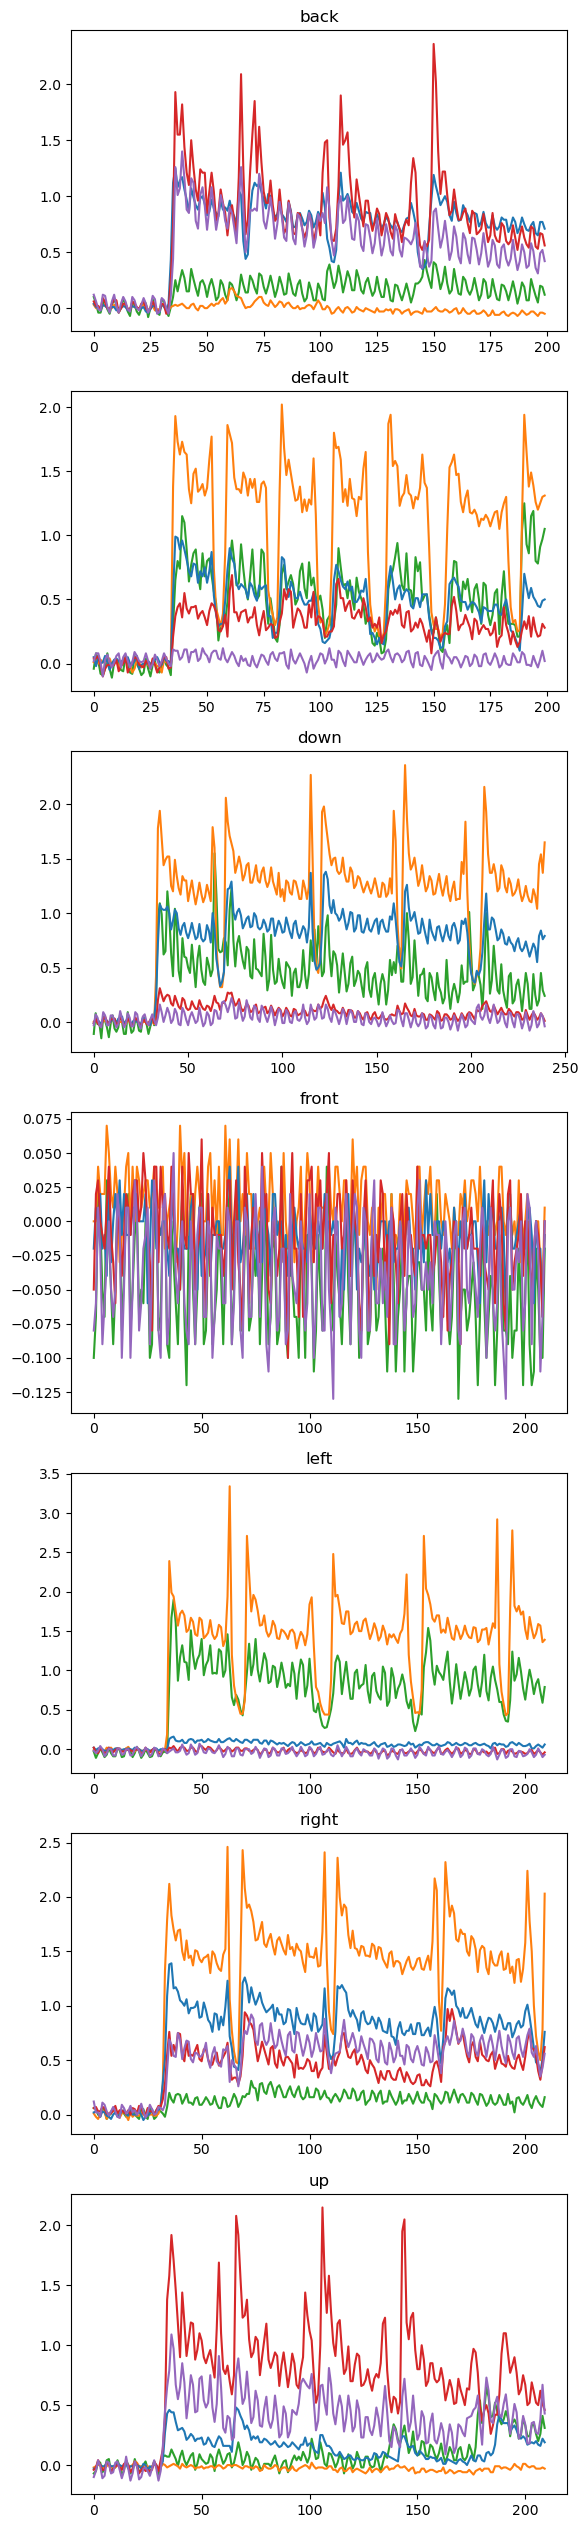

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 


fig, subplots = plt.subplots(nrows=7)
directions = (
    'back',
    'default',
    'down',
    'front',
    'left',
    'right',
    'up'
)
fig.set_figheight(32)
plt.plot()

ds = list(os.walk('version2'))
for i in range(0, 7):
    subplots[i].set_title(directions[i])

    dir, _, file = ds[i + 1]
    print()
    csv = os.path.join(dir, file[0])
    df = pd.read_csv(csv)
    subplots[i].plot(df['time'], df['thumb'], 'tab:green')
    subplots[i].plot(df['time'], df['index'], 'tab:orange')
    subplots[i].plot(df['time'], df['middle'], 'tab:blue')
    subplots[i].plot(df['time'], df['ring'], 'tab:red')
    subplots[i].plot(df['time'], df['little'], 'tab:purple')
    


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 


fig, subplots = plt.subplots(nrows=7)
directions = (
    'back',
    'default',
    'down',
    'front',
    'left',
    'right',
    'up'
)
fig.set_figheight(32)
plt.plot()

ds = list(os.walk('version2'))
for i in range(0, 7):
    subplots[i].set_title(directions[i])

    dir, _, file = ds[i + 1]
    print()
    arr = pd.DataFrame(['thumb', 'index', 'middle', 'ring', 'little', 'class'])
    for name in file:
        df = pd.read_csv(os.path.join(dir, name))
        
        
    csv = os.path.join(dir, file[0])
    df = pd.read_csv(csv)
    subplots[i].plot(df['time'], df['thumb'], 'tab:green')
    subplots[i].plot(df['time'], df['index'], 'tab:orange')
    subplots[i].plot(df['time'], df['middle'], 'tab:blue')
    subplots[i].plot(df['time'], df['ring'], 'tab:red')
    subplots[i].plot(df['time'], df['little'], 'tab:purple')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
A = np.asarray([1] * 5)
H = np.asarray([1] * 5)
Q = np.asarray([0.01] * 5)
R = np.asarray([4] * 5)

def update(z_meas, x_esti, P):
    x_pred = A * x_esti
    P_pred = (A **2) * P + Q

    K = P_pred * H / ((H ** 2) * P_pred + R)
    x_esti = x_pred + K * (z_meas - H * x_pred)

    P = P_pred - K * H * P_pred

    return x_esti, P

dir, _, file = list(os.walk('Dataset'))[5]
csv = os.path.join(dir, file[0])
df = pd.read_csv(csv)[['thumb', 'index', 'middle', 'ring', 'little']].to_numpy()

def KalmanFilter():
    x_k = 0
    P_k = 10
    filtered = []
    for z in df:
        x_k, P_k = update(z, x_k, P_k)
        filtered += [x_k]
    return filtered

fig, subplots = plt.subplots(nrows=10)
fig.set_figheight(32)
subplots[0].set_title('original')
subplots[0].plot(df)

for idx, q in enumerate(10.0 ** np.arange(0, -9, -1)):
    Q = np.asarray([q]* 5)
    subplots[idx+1].plot(KalmanFilter())

In [21]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

class2num = {'back': 0, 'default': 1, 'down': 2, 'front': 3, 'left': 4, 'right': 5, 'up': 6}
im = np.eye(7)
# im = im.reshape(6, -1, 6)
print(im.shape)

class MyDataset(Dataset):
    def __init__(self, path: str = 'Dataset', frame_length: int = 32):
        # 파일 이름 배열
        self.filenames = []
        # 파일 카테고리
        self.category = []
        # 학습 데이터
        self.data = np.ndarray([0, frame_length, 5])
        # 타겟 라벨
        self.label = np.ndarray([0, 7])
        
        # 파일 경로 로딩
        for dirname, _, filenames in os.walk(path):
            if len(filenames) == 0: continue

            _, category = os.path.split(dirname)
            self.filenames += [os.path.join(dirname, filename) for filename in filenames]
            self.category += [category] * len(filenames)
        
        # csv 로딩
        for idx, file in enumerate(self.filenames):

            # (file_frame_length, 6)
            frame = pd.read_csv(file)

            # (file_frame_length, 5)
            frame = frame[['thumb', 'index', 'middle', 'ring', 'little']].to_numpy()

            # (file_frame_length + 50 > 160, 5)
            # frame[file_frame_length - 1] 값으로 패딩
            frame = np.pad(frame, ((0, 200), (0, 0)), mode='edge')
            
            batch = []
            for i in range(40, 136):
                batch += [frame[i: i + 32]]
                batch += [frame[i + 32: i: -1]]
            # TODO: 프레임 1마다 한 주기씩 만들기
            # (128 / frame_length, frame_length, 5)
            batch = np.asarray(batch)
            # (total_file * 128 / frame_length, frame_length, 5)
            self.data = np.append(self.data, batch, axis=0)
            
            # (total_file * 128 / frame_length, 6)
            self.label = np.append(self.label, [im[class2num[self.category[idx]]]] * len(batch), axis=0)

        print(self.data.shape, self.label.shape)

        # 정규화
        mean = self.data.mean(axis=0)
        std = self.data.std(axis=0)
        
        self.data = (self.data - mean) / std

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y
    
MyDataset()

(7, 7)
(13440, 32, 5) (13440, 7)


In [22]:
from torch.utils.data import DataLoader, random_split

dataset = MyDataset(frame_length=32)
dataset_length = len(dataset)
train_length = int(dataset_length * 0.8)
test_length = int(dataset_length * 0.1)
valid_length = dataset_length - train_length - test_length
train_dataset, test_dataset, validation_dataset = random_split(dataset, [train_length, test_length, valid_length])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

print(train_length)
print(test_length)
print(valid_length)

(13440, 32, 5) (13440, 7)
10752
1344
1344


In [261]:
import torch.nn as nn
import torch
from torch.nn import Module, Sequential

class MyModel(Module):
    def __init__(self, filter_size: int = 8, frame_length: int = 8):
        super(MyModel, self).__init__()

        self.layer_1 = Sequential(*[
            nn.Conv1d(5, filter_size, 3, padding=1),
            nn.BatchNorm1d(filter_size),
            nn.ReLU(),
            nn.MaxPool1d(2)
        ])

        self.layer_2 = Sequential(*[
            nn.Conv1d(filter_size, 2 * filter_size, 3, padding=1),
            nn.BatchNorm1d(2 * filter_size),
            nn.ReLU(),
            nn.MaxPool1d(2)
        ])

        self.fc = Sequential(*[
            nn.Flatten(),
            nn.Linear(int((frame_length * filter_size) / 2), 7),
            nn.Sigmoid(),
            nn.Softmax(dim=1)
        ])

        self.drop = nn.Dropout()

    def forward(self, input: torch.FloatTensor):
        out_1 = self.layer_1(input.transpose(1, 2))
        out_2 = self.layer_2(
            self.drop(out_1) if self.training else out_1
        )
        return self.fc(out_2)

In [262]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from pytorch_model_summary import summary

model = MyModel(filter_size=4, frame_length=32)
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters())

# print(summary(model, torch.FloatTensor(size=(32, 16, 5))))

  4%|▎         | 108/3000 [00:01<00:43, 66.64it/s]

[(tensor([0.1220, 0.2060, 0.1252, 0.1247, 0.2976, 0.1246]), tensor([0., 1., 0., 0., 0., 0.])), (tensor([0.2823, 0.1076, 0.1059, 0.2785, 0.1160, 0.1098]), tensor([1., 0., 0., 0., 0., 0.])), (tensor([0.1129, 0.1215, 0.2798, 0.1111, 0.1144, 0.2603]), tensor([0., 0., 1., 0., 0., 0.])), (tensor([0.1213, 0.2028, 0.1246, 0.1226, 0.3071, 0.1216]), tensor([0., 0., 0., 0., 1., 0.])), (tensor([0.2438, 0.1133, 0.1267, 0.2334, 0.1126, 0.1703]), tensor([0., 0., 0., 1., 0., 0.])), (tensor([0.1202, 0.2105, 0.1246, 0.1241, 0.2962, 0.1244]), tensor([0., 1., 0., 0., 0., 0.])), (tensor([0.1201, 0.2035, 0.1215, 0.1216, 0.3135, 0.1198]), tensor([0., 0., 0., 0., 1., 0.])), (tensor([0.1217, 0.1911, 0.1211, 0.1227, 0.3225, 0.1210]), tensor([0., 0., 0., 0., 1., 0.]))]
[(tensor([0.2455, 0.1172, 0.1225, 0.2268, 0.1173, 0.1705]), tensor([0., 0., 0., 1., 0., 0.])), (tensor([0.1206, 0.1995, 0.1206, 0.1222, 0.3167, 0.1204]), tensor([0., 0., 0., 0., 1., 0.])), (tensor([0.2874, 0.1058, 0.1057, 0.2872, 0.1080, 0.1058]),

100%|██████████| 3000/3000 [00:42<00:00, 70.24it/s]


[tensor(0.1250), tensor(0.1250), tensor(0.), tensor(0.1250), tensor(0.1250), tensor(0.1429), tensor(0.1250), tensor(0.2500), tensor(0.), tensor(0.1250), tensor(0.1250), tensor(0.1429), tensor(0.1250), tensor(0.2500), tensor(0.2857), tensor(0.2500), tensor(0.3750), tensor(0.1429), tensor(0.1250), tensor(0.5000), tensor(0.2857), tensor(0.1250), tensor(0.2500), tensor(0.7143), tensor(0.6250), tensor(0.2500), tensor(0.2857), tensor(0.5000), tensor(0.6250), tensor(0.2857), tensor(0.3750), tensor(0.7500), tensor(0.2857), tensor(0.5000), tensor(0.6250), tensor(0.1429), tensor(0.2500), tensor(0.5000), tensor(0.5714), tensor(0.3750), tensor(0.3750), tensor(0.5714), tensor(0.5000), tensor(0.3750), tensor(0.4286), tensor(0.3750), tensor(0.3750), tensor(0.5714), tensor(0.5000), tensor(0.2500), tensor(0.5714), tensor(0.5000), tensor(0.5000), tensor(0.2857), tensor(0.3750), tensor(0.3750), tensor(0.4286), tensor(0.3750), tensor(0.3750), tensor(0.4286), tensor(0.2500), tensor(0.3750), tensor(0.5714),

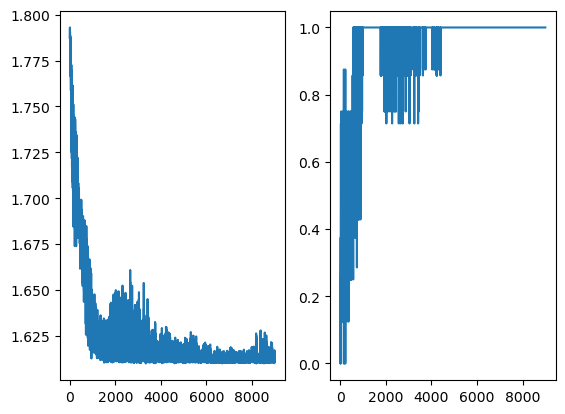

In [263]:
from tqdm import tqdm
import matplotlib.pyplot as plt



loss_gp = []
acc_gp = []
with torch.device('cuda' if torch.cuda.is_available() else 'cpu') as device:
    for epoch in tqdm(range(3000)):
        for ((train_data, train_label), (vaild_data, valid_label)) in zip(train_loader, valid_loader):
            # print(train_data.get_device())
            model.train(True)
            optimizer.zero_grad()
            train_output = model(train_data)
            loss = loss_fn(train_output, train_label)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                model.train(False)
                valid_output = model(vaild_data)
                valid_loss = loss_fn(valid_output, valid_label)
                pred = valid_output.argmax(dim=1)
                target = valid_label.argmax(dim=1)

                train_acc = torch.sum(pred == target)
                if epoch == 99:
                    print(list(zip(valid_output, valid_label)))
                loss_gp += [valid_loss]
                acc_gp += [train_acc / pred.shape[0]]

fig, (l, a) = plt.subplots(ncols=2)

l.plot(loss_gp)
a.plot(acc_gp)
print(acc_gp)

In [264]:
with torch.no_grad():
    for (data, label) in test_loader:
        output = model(data)
        print(output.argmax(dim=1))
        print(label.argmax(dim=1))

tensor([1, 5, 1, 0, 3, 5, 3, 0])
tensor([1, 5, 1, 0, 3, 5, 3, 0])
tensor([2, 1, 2, 3, 1, 0, 0, 0])
tensor([2, 1, 2, 3, 1, 0, 0, 0])
tensor([4, 1, 1, 0, 1])
tensor([4, 1, 1, 0, 1])
